In [1]:
%load_ext autoreload
%autoreload 2
import sys 
if '/Users/ericliu/Desktop/Latent-Dirichilet-Allocation' not in sys.path: 
    sys.path.append('/Users/ericliu/Desktop/Latent-Dirichilet-Allocation')
import torch as tr 
import numpy as np 
import pandas as pd 
from collections import defaultdict
from pprint import pprint
import matplotlib.pyplot as plt 

from sklearn.decomposition import LatentDirichletAllocation 
from src.lda_model import LDASmoothed 
from src.generator import doc_generator 
from src.utils import (
    get_vocab_from_docs, 
    get_np_wct, 
    data_loader,
    text_pipeline, 
    process_documents,
    compute_elbo,
) 
from src.text_pre_processor import (
    remove_accented_chars, 
    remove_special_characters, 
    remove_punctuation,
    remove_extra_whitespace_tabs,
    remove_stopwords,
)
from pprint import pprint 
import copy  

from src.cutils import (
    _dirichlet_expectation_1d, 
    _dirichlet_expectation_2d,
)

/Users/ericliu/Desktop/Latent-Dirichilet-Allocation/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Document Generation

In [2]:
gen = doc_generator(
    M = 100,
    L = 20, 
    topic_prior = tr.tensor([1,1,1,1,1], dtype=tr.double)
)

In [3]:
gen.alpha

Dirichlet(concentration: torch.Size([5]))

In [4]:
gen.theta.shape

torch.Size([100, 5])

In [5]:
#gen.theta

In [6]:
docs = gen.generate_doc()

In [7]:
#docs_raw_dict, raw_word_2_idx, raw_idx_2_word = data_loader('ap')

In [8]:
result = process_documents(docs, sample=True)

There are 100 documents in the dataset after processing
On average estimated document length is 10.0 words per document after processing
There are 40 unique vocab in the corpus after processing


In [9]:
print(result.keys())

dict_keys(['documents', 'vocab_doc_count_dict', 'vocab_doc_count_array', 'vocab_to_idx', 'idx_to_vocab'])


In [10]:
doc_vocab_count = np.zeros(
    (
        len(docs), len(result['vocab_to_idx'])
    ),
    dtype = float,
)

for doc_idx, doc in enumerate(result['documents']): 
    for word in doc: 
        vocab_idx = result['vocab_to_idx'][word]
        doc_vocab_count[doc_idx, vocab_idx] += 1 

print(doc_vocab_count.shape)

(100, 40)


In [11]:
doc_vocab_count_df = pd.DataFrame(
    data = doc_vocab_count,
    columns = list(result['vocab_to_idx'].keys())
)
doc_vocab_count_df

,appetite,divorce,genetics,court,infection,bankrupt,game,evidence,asymmetrical,energy,...,astrophysics,copyright,picture,electricity,Olympic,exercise,research,physical,contract,fever
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
96,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
97,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
98,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Our Model

Topic Dirichlet Prior, Alpha
1

Exchangeable Word Dirichlet Prior, Eta 
1

Var Inf - Word Dirichlet prior, Lambda
(5, 40)

Var Inf - Topic Dirichlet prior, Gamma
(100, 5)

Size of the vocab is 40
Init perplexity = 98.31667858811902
End perplexity = 52.72568050990828


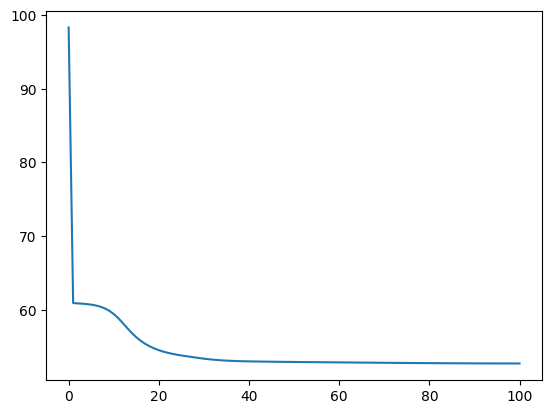

In [12]:
lda = LDASmoothed(
    docs = result['documents'],
    num_topics = 5, 
    word_ct_dict = result['vocab_doc_count_dict'], 
    num_doc_population = 100,
    word_ct_array = result['vocab_doc_count_array'],
)
print(f'Size of the vocab is {lda.V}')
lambda_init = lda._lambda_ 

perplexes = lda.partial_fit(
    X = doc_vocab_count,
    sampling= False,
    verbose=True, 
    return_perplexities=True,
)

plt.plot(perplexes)

In [13]:
lda.idx_2_word

{0: 'appetite',
 1: 'divorce',
 2: 'genetics',
 3: 'court',
 4: 'infection',
 5: 'bankrupt',
 6: 'game',
 7: 'evidence',
 8: 'asymmetrical',
 9: 'energy',
 10: 'content',
 11: 'concert',
 12: 'attorney',
 13: 'recreation',
 14: 'Craftsmanship',
 15: 'Symmetrical',
 16: 'form',
 17: 'immunology',
 18: 'contagious',
 19: 'bruise',
 20: 'injection',
 21: 'FIFA',
 22: 'allergy',
 23: 'scientst',
 24: 'accuse',
 25: 'decongestant',
 26: 'Technique',
 27: 'football',
 28: 'athletics',
 29: 'quantum',
 30: 'astrophysics',
 31: 'copyright',
 32: 'picture',
 33: 'electricity',
 34: 'Olympic',
 35: 'exercise',
 36: 'research',
 37: 'physical',
 38: 'contract',
 39: 'fever'}

In [328]:
lda._lambda_[0,30]

24.698337933407675

- As we can see, without update the hyper-parameter $\alpha$ and $\eta$, we extract keywords from topics almost correctly. 

Although we still can see that some are not perfect, i.e. electricity ranked higher than scientist 

In [331]:
for topic_index in range(lda._lambda_.shape[0]):

    top5 = np.argsort(lda._lambda_[topic_index,:],)[-5:]
    print(f"Topic {topic_index}")
    for i, idx in enumerate(top5):
        print(f"Top {i+1} -> {lda.idx_2_word[idx]}")
    print()

Topic 0
Top 1 -> electricity
Top 2 -> scientst
Top 3 -> astrophysics
Top 4 -> quantum
Top 5 -> research

Topic 1
Top 1 -> divorce
Top 2 -> accuse
Top 3 -> bankrupt
Top 4 -> athletics
Top 5 -> contract

Topic 2
Top 1 -> immunology
Top 2 -> exercise
Top 3 -> fever
Top 4 -> allergy
Top 5 -> genetics

Topic 3
Top 1 -> bruise
Top 2 -> football
Top 3 -> game
Top 4 -> picture
Top 5 -> recreation

Topic 4
Top 1 -> FIFA
Top 2 -> injection
Top 3 -> Olympic
Top 4 -> content
Top 5 -> Symmetrical



# Target model

alpha -> 1
eta -> 1
lambda
(5, 40)
Init perplexity = 96.11245703458475
End perplexity = 51.967395414788584


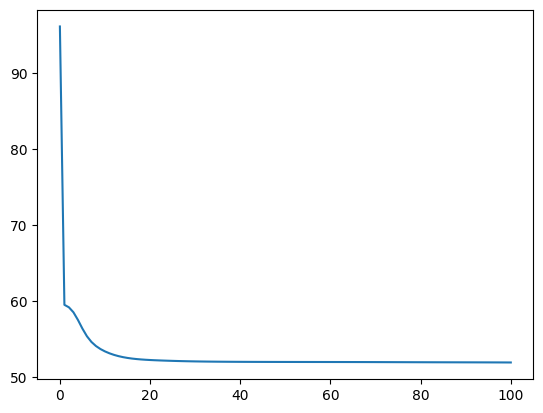

In [316]:
sklearn_lda = LatentDirichletAllocation(
    n_components=5,
    random_state=42,
    doc_topic_prior= 1,
    topic_word_prior= 1,
)
sklearn_lda._init_latent_vars(n_features = lda.V)

print(f"alpha -> {sklearn_lda.doc_topic_prior}")
print(f"eta -> {sklearn_lda.topic_word_prior}")

print('lambda')
print(sklearn_lda.components_.shape)
assert (sklearn_lda.components_ == lambda_init).all()

perplxities_sklearn = []
init_perplexity = sklearn_lda._perplexity_precomp_distr(
    doc_vocab_count, 
    doc_topic_distr = lda._gamma_,
    sub_sampling=False
)
print(f"Init perplexity = {init_perplexity}")
perplxities_sklearn.append(init_perplexity)

for i in range(100):
    
    sklearn_lda._em_step(doc_vocab_count, doc_vocab_count.shape[0], True, )

    em_step_perplexity = sklearn_lda.perplexity(doc_vocab_count)
    #print(f"{i+1} EM step perplexity is {em_step_perplexity}")
    perplxities_sklearn.append(em_step_perplexity)
print(f"End perplexity = {perplxities_sklearn[-1]}")
plt.plot(perplxities_sklearn)